In [23]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot
import os
from tqdm import tqdm
import collections
import itertools
import pickle
import matplotlib.dates as md


from pix_framework.statistics.distribution import DurationDistribution, get_best_fitting_distribution, DistributionType

import sys
sys.path.append('../../TaskExecutionTimeMining/')
from drbart_parser import *
from event_log_transformer import *

sys.path.append('../../Evaluation/')
from process_evaluation import *

In [2]:
file_path = '../../../data/BPI Challenge 2017.xes'
event_log = pm4py.read_xes(file_path)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [36]:
event_log = TransformEventLog.seconds_in_day(event_log)

In [3]:
from dumas_model import DumasModel

dm = DumasModel(event_log)


with open('../../../models/bpic_2017_dumas_model/dumas_model.pickle', 'wb') as handle:
    pickle.dump(dm, handle)


/home/michel/Documents/TaskExecutionTimeMining/src/notebooks/BPIC_2017/../../TaskExecutionTimeMining/event_log_transformer.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_end_event_log.loc[:, 'duration'] = start_end_event_log[timestamp_name + complete_name_gen] - start_end_event_log[timestamp_name + start_name_gen]
/home/michel/Documents/TaskExecutionTimeMining/src/notebooks/BPIC_2017/../../TaskExecutionTimeMining/event_log_transformer.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_en

KeyboardInterrupt: 

In [6]:
with open('../../../models/bpic_2017_dumas_model/dumas_model.pickle', 'rb') as handle:
    dm = pickle.load(handle)

In [38]:
import importlib
importlib.reload(sys.modules['process_evaluation'])
from process_evaluation import *

dumas_model = SampleOutcomes_Dumas_BPIC2017(event_log, dm)


/tmp/ipykernel_318935/287478273.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


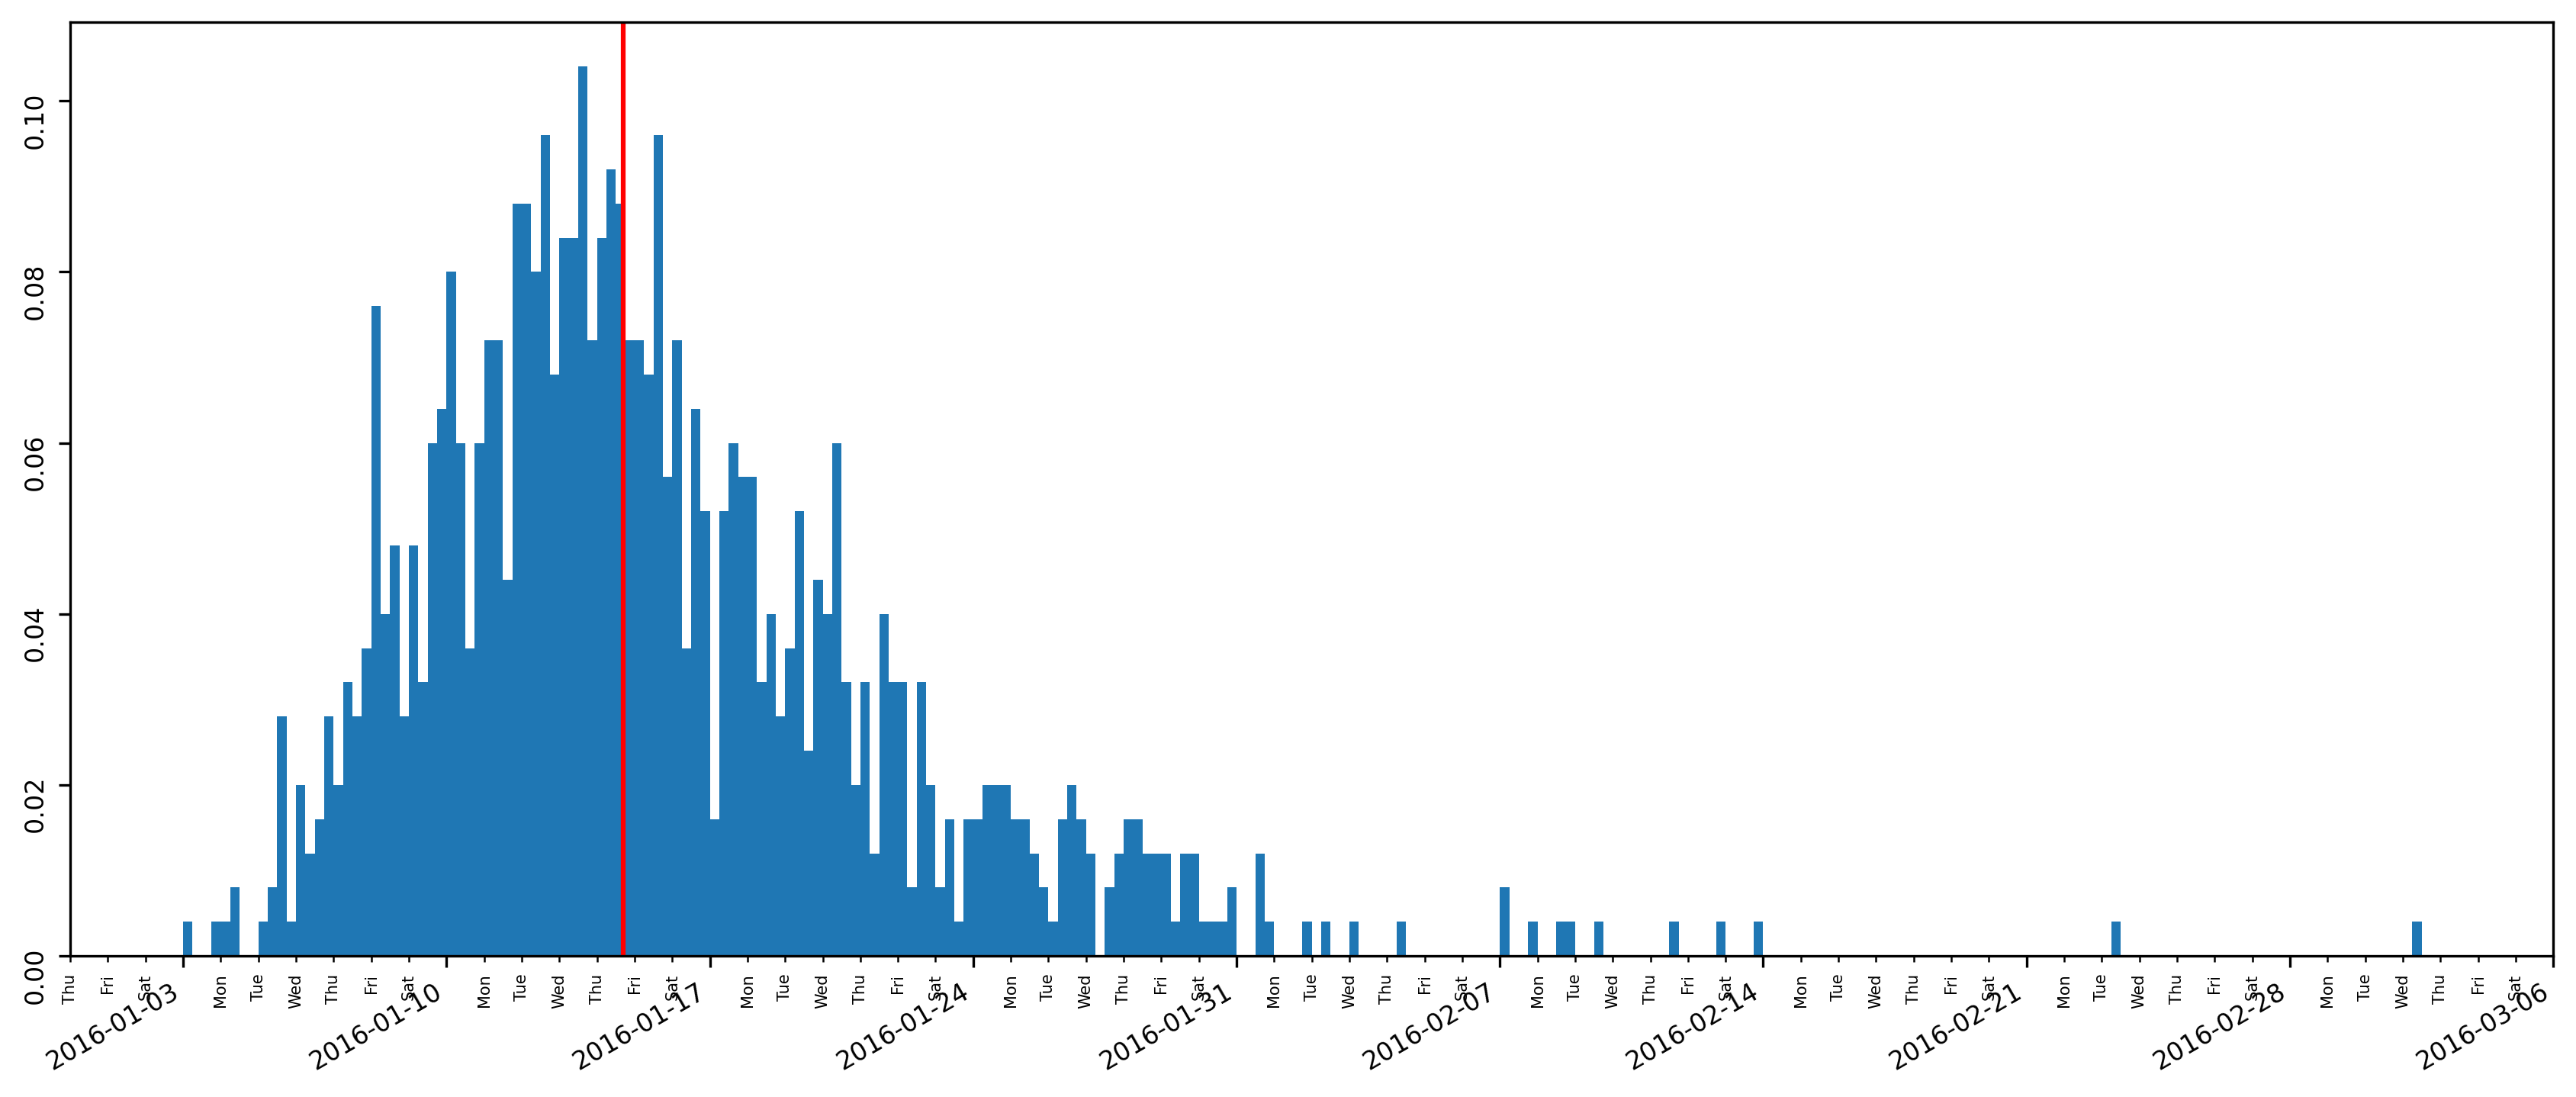

Application_652823628 [0.07432164] 2016-01-03 03:20:13.005220 2016-03-02 08:56:41.902794 59 days, 5:36:28.897574


/tmp/ipykernel_318935/287478273.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


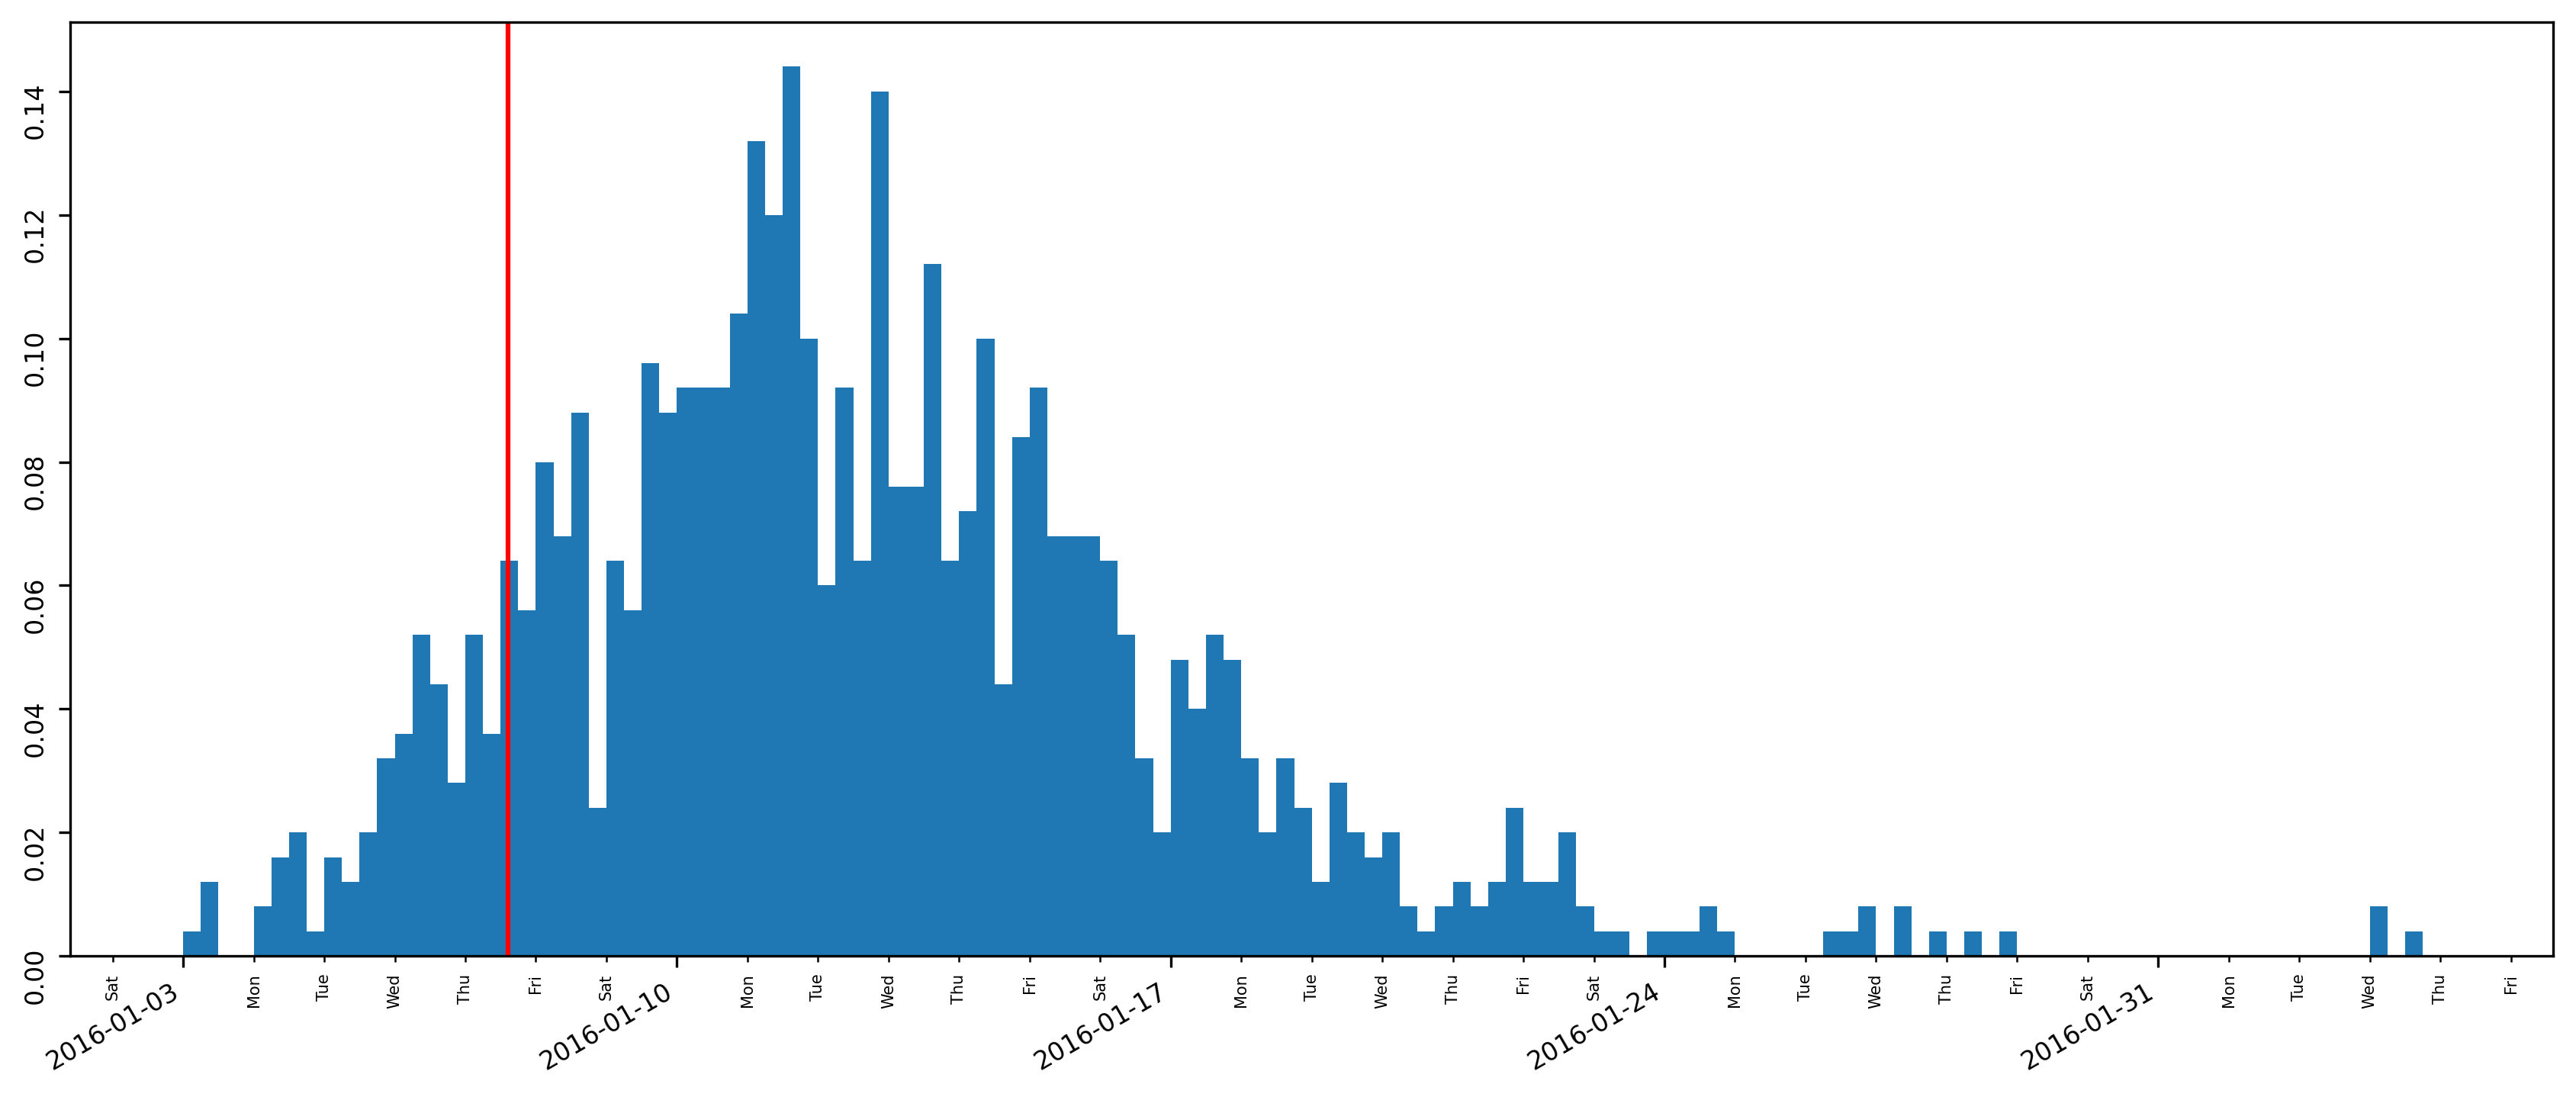

Application_1691306052 [0.053308] 2016-01-03 04:23:10.408558 2016-02-03 16:59:32.684068 31 days, 12:36:22.275510


/tmp/ipykernel_318935/287478273.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)


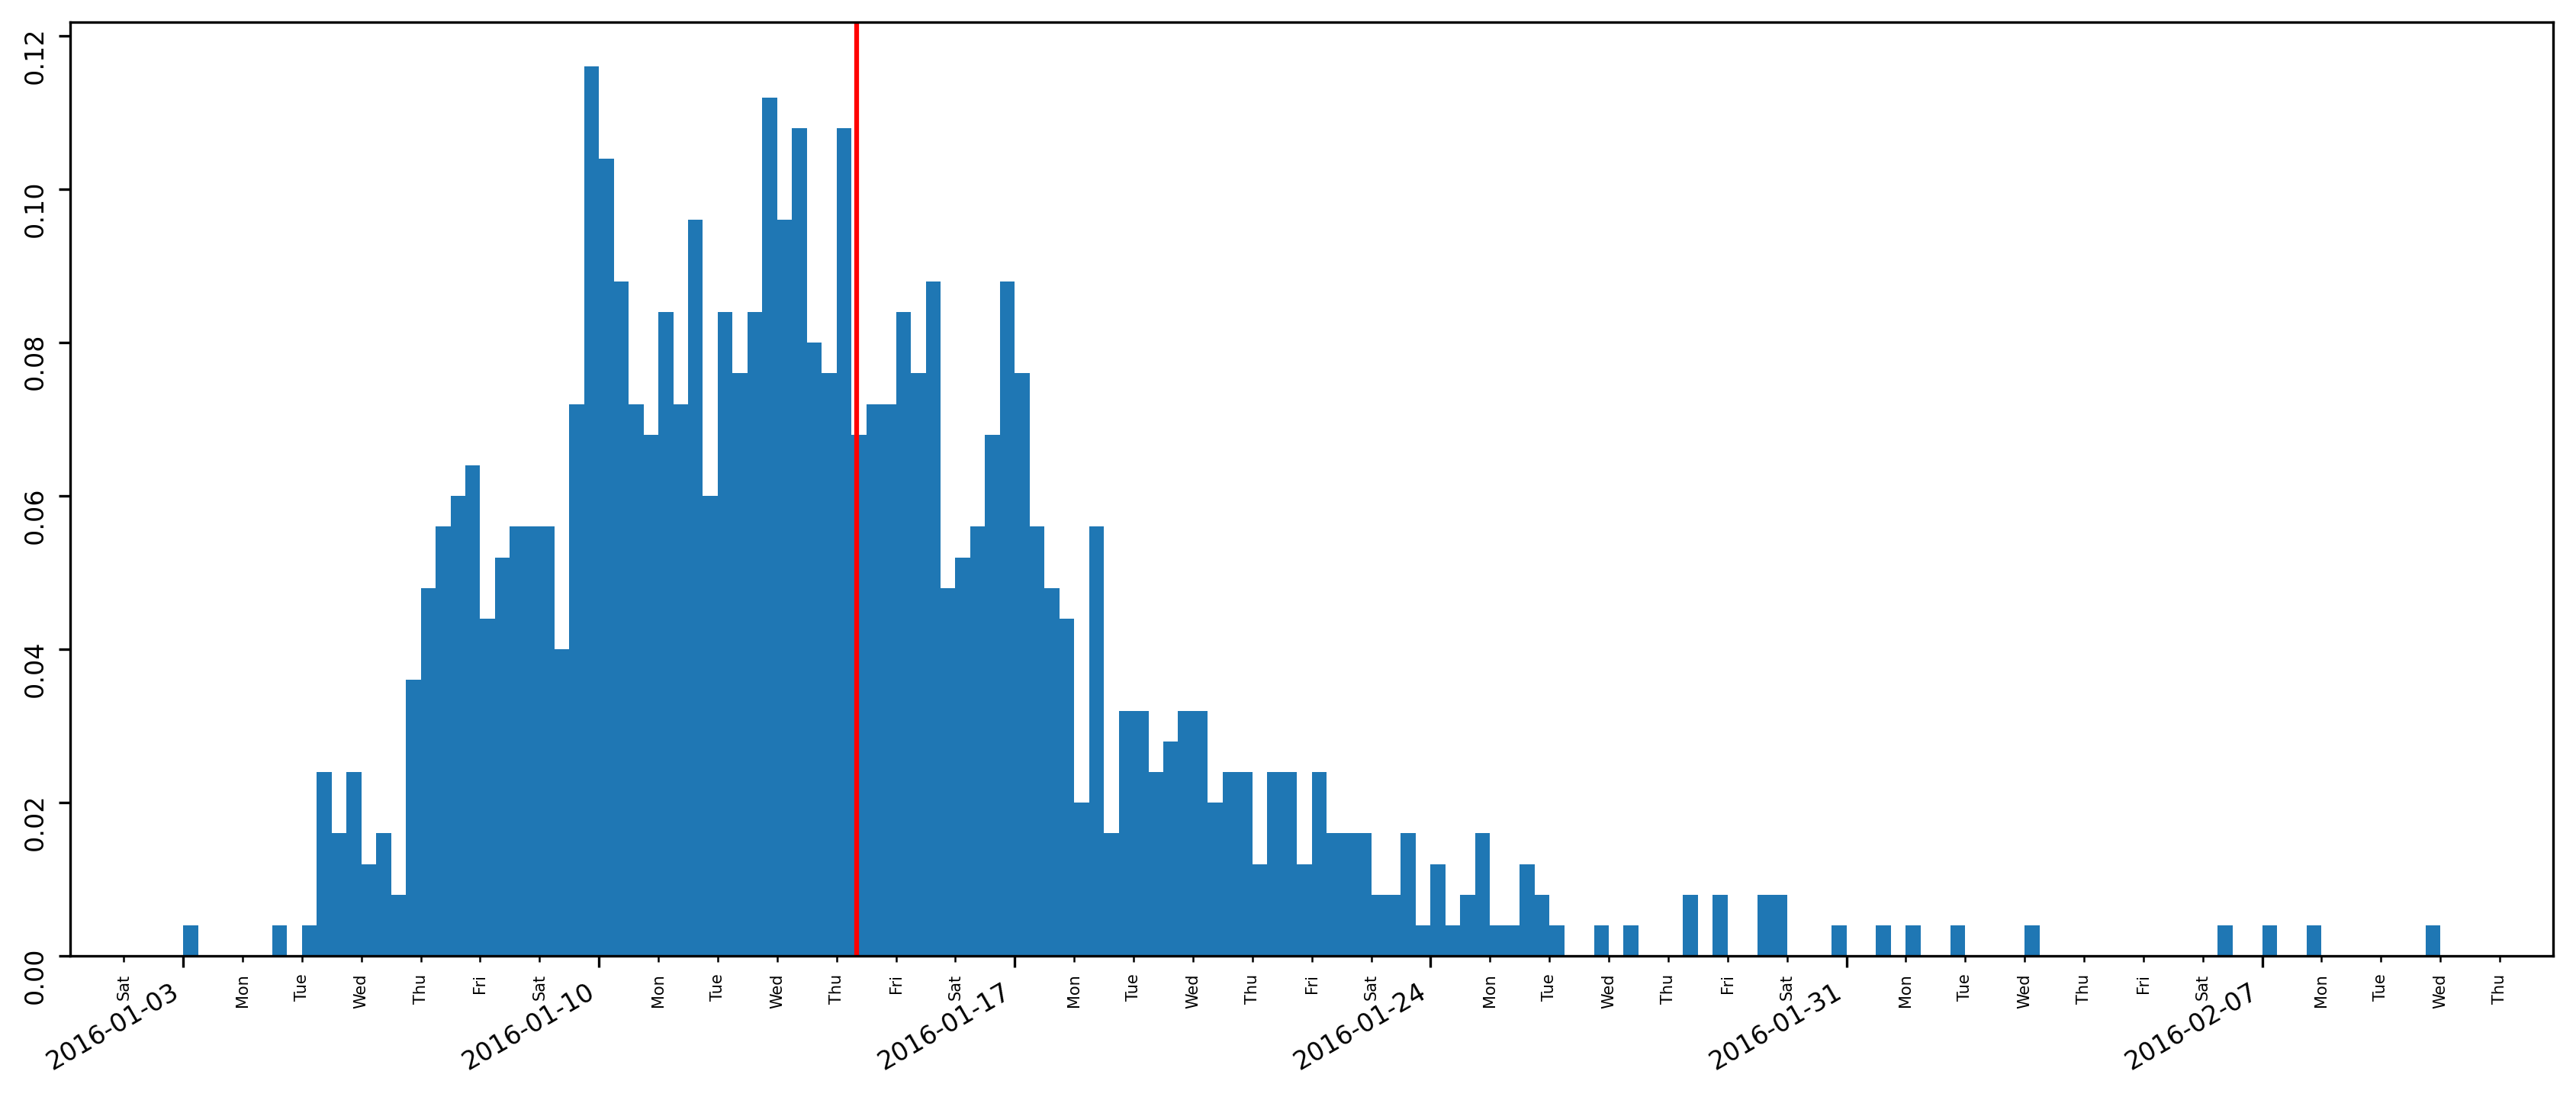

Application_428409768 [0.08129026] 2016-01-03 04:36:36.554721 2016-02-09 18:35:08.486306 37 days, 13:58:31.931585


In [ ]:
from pm4py.objects.petri_net import semantics
from scipy.stats import gaussian_kde


get_real_end_time = lambda case_name : event_log[(event_log['case:concept:name'] == case_name)]['time:timestamp'].max().timestamp()
results = []
n = 1000
for case_name in event_log['case:concept:name'].unique():
    case_samples = [dumas_model.sample_case(case_name) for i in range(n)]
    real_end_time = get_real_end_time(case_name)

    likelihood = kde_likelihood(case_samples, real_end_time) * (3600*24)
    
    case_samples = [datetime.datetime.fromtimestamp(ts) for ts in case_samples]
    real_end_time = datetime.datetime.fromtimestamp(real_end_time)

    plt.figure(figsize=(14, 6))
    #plt.xticks( rotation=25 )
    #print(case_samples)
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=md.SU, interval=1))
    mxfmt = md.DateFormatter('%a')
    ax.xaxis.set_minor_formatter(mxfmt)
    ax.xaxis.set_minor_locator(md.DayLocator())
    ax.tick_params(axis='both', which='major', labelsize=8, rotation=90)
    ax.tick_params(axis='both', which='minor', labelsize=5, rotation=90)
    
    plt.gcf().autofmt_xdate()
    plt.gcf().set_dpi(300)
    plt.hist(case_samples, bins=pandas.date_range(start= pandas.to_datetime(min(case_samples)).floor('D'), end=pandas.to_datetime(max(case_samples)).ceil('D'), freq='6H'), density=True)
    plt.axvline(x=real_end_time, color='red')
    plt.show()
    results.append(likelihood[0])
    print(case_name, likelihood, min(case_samples), max(case_samples),  max(case_samples)-min(case_samples))

In [15]:
results

[0.07142641506328078,
 0.04297915573548038,
 0.08481727228178844,
 0.042737826278242186,
 7.777663884503736e-12,
 0.0,
 0.0018546256824031827,
 0.09436214957984,
 0.025940551649729644,
 0.00017431651179108278,
 0.019183027924774224,
 7.202458811074706e-29,
 0.060075830572005134,
 1.724063392663316e-207,
 0.023480419818888276,
 8.488314133701019e-05,
 0.10631724365507858,
 0.09425012363309716,
 2.378350663314301e-05,
 0.06409096719246066,
 0.0005241924255072833,
 0.019492081896231844,
 0.010966609908138292,
 0.08036112538862354,
 0.055033222649462886,
 0.0,
 0.1517650680179106,
 2.9636225380820996e-05,
 2.17288855307869e-100,
 0.0003349257941230758,
 0.026582364041111278,
 0.0009197111056779617,
 0.03628123752365513,
 0.07019276067843161,
 0.0,
 0.0544707393961916,
 0.05437658624288125,
 0.045345920719567945,
 0.1027906090479126,
 0.08874871873707817,
 0.07417623567987991,
 0.0004229569523120149,
 0.01978768390538277,
 0.014907475199528735,
 0.06286835755447019,
 0.056874869013728124,
 

In [16]:
ll = np.log(np.array(results))
ll

/tmp/ipykernel_318935/3631835585.py:1: RuntimeWarning: divide by zero encountered in log
  ll = np.log(np.array(results))


array([  -2.63908752,   -3.14704003,   -2.46725607,   -3.15267089,
        -25.57976509,          -inf,   -6.29007239,   -2.36061524,
         -3.65194783,   -8.65463788,   -3.95372935,  -64.80054523,
         -2.81214767, -476.09043031,   -3.7515884 ,   -9.37423506,
         -2.24132779,   -2.36180314,  -10.64651822,   -2.74745184,
         -7.55365172,   -3.93774695,   -4.51290009,   -2.52122473,
         -2.89981823,          -inf,   -1.88542156,  -10.42651311,
       -229.48245189,   -8.00160156,   -3.62750729,   -6.99145095,
         -3.31645454,   -2.6565101 ,          -inf,   -2.91009161,
         -2.91182162,   -3.09343506,   -2.27506128,   -2.42194629,
         -2.60131145,   -7.76824015,   -3.92269556,   -4.2058925 ,
         -2.7667123 ,   -2.8669017 ,   -2.6138739 ,   -3.51101331,
         -3.2943615 ,  -46.88453681,   -9.73553405,   -2.70523813,
         -2.78537026,   -2.14784391,   -6.70901972])

In [19]:
ll[:28]
np.median(ll[:28])

-3.8446676784054423

In [20]:
np.mean(np.array(results[:28]))

0.03749894745520939